In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
!pip install pmdarima
from pmdarima import auto_arima

# Reading the data

In [277]:
excel_file_path = '/content/Rain.csv'

# Read the Excel file into a DataFrame
rain_df = pd.read_csv(excel_file_path)
rain_df

,Year,Region,Value
0,2013,N-Western,296.00
1,2014,N-Western,139.30
2,2015,N-Western,170.00
3,2016,N-Western,219.30
4,2017,N-Western,226.23
...,...,...,...
75,2018,Coastal,1314.20
76,2019,Coastal,1482.00
77,2020,Coastal,938.50
78,2021,Coastal,495.20


In [278]:
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Year    80 non-null     int64  
 1   Region  80 non-null     object 
 2   Value   80 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.0+ KB


#DATA CLEANING AND PREPROCESSING

In [279]:
#let us convert the first column to date time
rain_df['Year'] = pd.to_datetime(rain_df['Year'].astype(str), format='%Y')
rain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Year    80 non-null     datetime64[ns]
 1   Region  80 non-null     object        
 2   Value   80 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.0+ KB


Because we are trying to predict the rainfall for each county, we shall look at each county uniquely


In [280]:
#Creating different table variations dependent on the region
df_dict = {}

for i in range(0,len(rain_df['Region'].unique())):
  region= rain_df['Region'].unique()[i]
  region_df= rain_df[rain_df['Region']==region]
  df_dict[region]=region_df
df_dict.keys()

dict_keys(['N-Western', 'N-Eastern', 'Western', 'C-Rift Valley', 'Central', 'Nairobi', 'S-Eastern', 'Coastal'])

In [281]:
#Now we have each region with its own table
df_dict['N-Western']

,Year,Region,Value
0,2013-01-01,N-Western,296.00
1,2014-01-01,N-Western,139.30
2,2015-01-01,N-Western,170.00
3,2016-01-01,N-Western,219.30
4,2017-01-01,N-Western,226.23
5,2018-01-01,N-Western,282.70
6,2019-01-01,N-Western,309.50
7,2020-01-01,N-Western,380.80
8,2021-01-01,N-Western,176.50
9,2022-01-01,N-Western,103.60


In [282]:
df_dict

{'N-Western':         Year     Region   Value
 0 2013-01-01  N-Western  296.00
 1 2014-01-01  N-Western  139.30
 2 2015-01-01  N-Western  170.00
 3 2016-01-01  N-Western  219.30
 4 2017-01-01  N-Western  226.23
 5 2018-01-01  N-Western  282.70
 6 2019-01-01  N-Western  309.50
 7 2020-01-01  N-Western  380.80
 8 2021-01-01  N-Western  176.50
 9 2022-01-01  N-Western  103.60,
 'N-Eastern':          Year     Region  Value
 10 2013-01-01  N-Eastern  529.0
 11 2014-01-01  N-Eastern  396.6
 12 2015-01-01  N-Eastern  394.2
 13 2016-01-01  N-Eastern  367.0
 14 2017-01-01  N-Eastern  367.7
 15 2018-01-01  N-Eastern  971.3
 16 2019-01-01  N-Eastern  555.3
 17 2020-01-01  N-Eastern  427.0
 18 2021-01-01  N-Eastern  247.7
 19 2022-01-01  N-Eastern  246.1,
 'Western':          Year   Region   Value
 20 2013-01-01  Western  1793.6
 21 2014-01-01  Western  1508.4
 22 2015-01-01  Western  1690.8
 23 2016-01-01  Western  1407.2
 24 2017-01-01  Western  1715.1
 25 2018-01-01  Western  1830.5
 26 2019-01

# EDA

## Univariate analysis

Here, we shall look at the distribution of rainfall in general to get an idea of its behaviour


Let us start with having a look at the rainfall pattern for each county

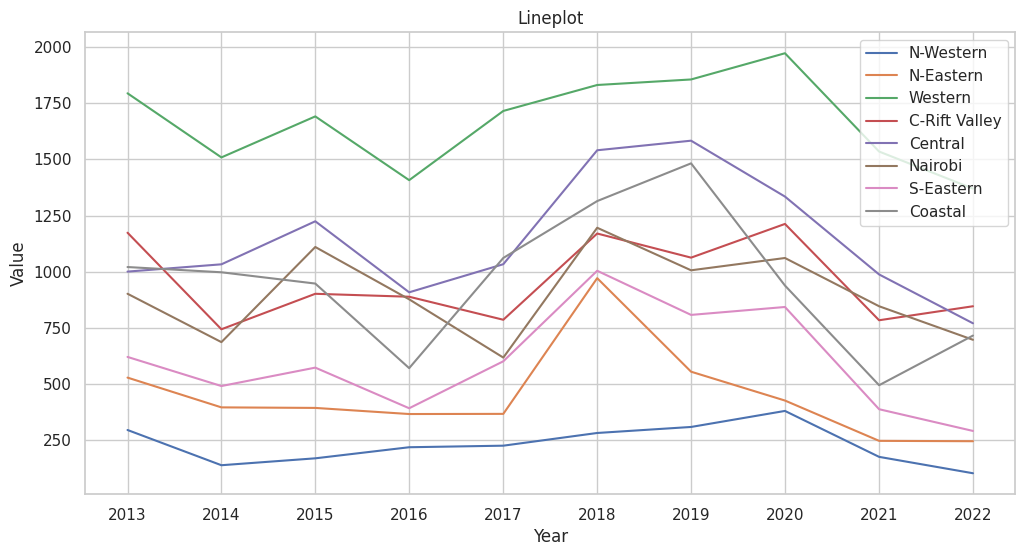

In [283]:
plt.figure(figsize=(12, 6))

for key, data in df_dict.items():
    plt.plot(data['Year'], data['Value'], label=key)

plt.title('Lineplot')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend()
plt.show()

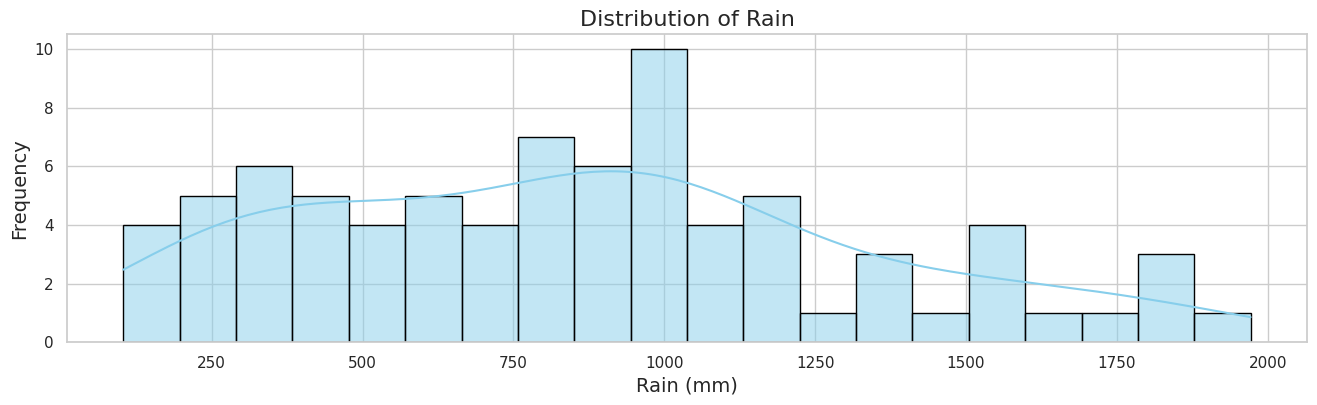

In [284]:
# Plotting the distribution of prices
sns.set(style="whitegrid")
plt.figure(figsize=(16, 4))
sns.histplot(rain_df['Value'], kde=True, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Rain', fontsize=16)
plt.xlabel('Rain (mm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

plt.show()


The data is slightly skewed to the left but the distribution is mostly normal.

Let us take a look at the outliers using a box plot

<ipython-input-285-429d33f07be1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=rain_df['Value'], palette = 'Set2')


[]

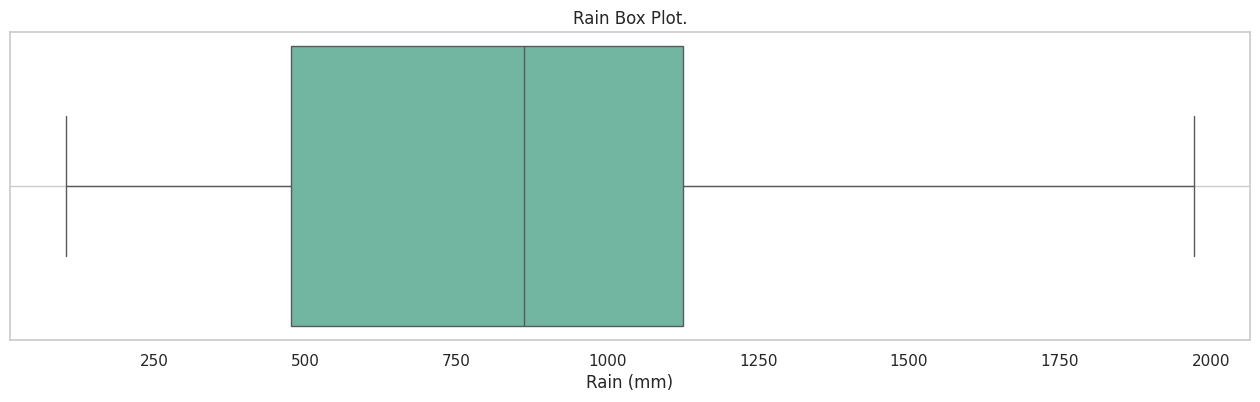

In [285]:
#box plot
plt.figure(figsize=(16,4))
sns.boxplot(x=rain_df['Value'], palette = 'Set2')
plt.title('Rain Box Plot.')
plt.xlabel('Rain (mm)')
plt.grid()
plt.plot()

Given that we saw the data was somewhat normarly distributed, then as was anticapated there are no outliers.

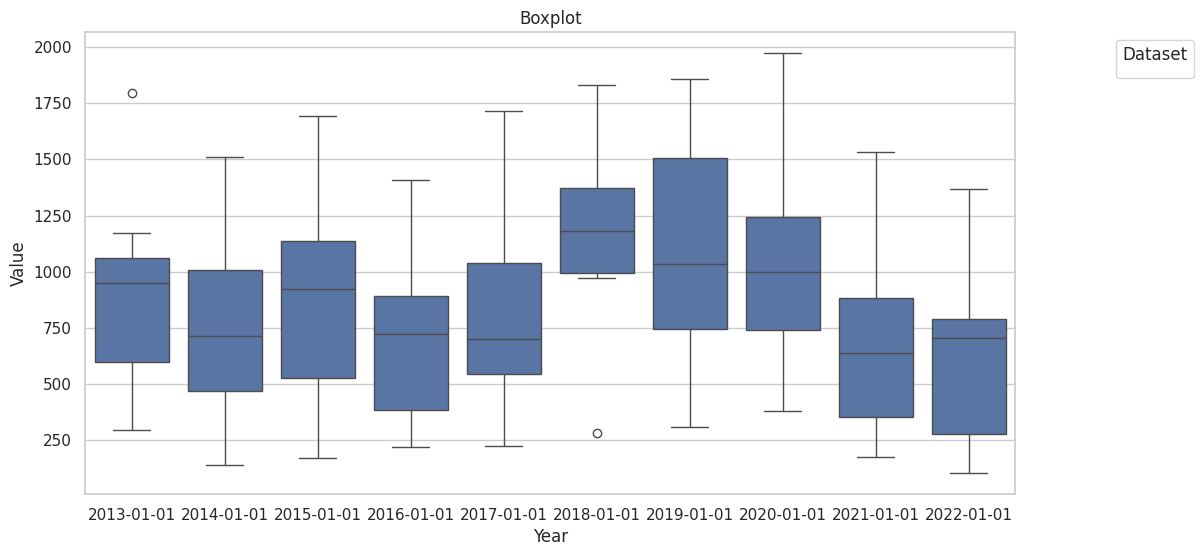

In [286]:
#let us look at the box plot for each county

plt.figure(figsize=(12, 6))
sns.boxplot(x='Year', y='Value', data=pd.concat(df_dict.values()), hue_order=df_dict.keys())

plt.title('Boxplot')
plt.xlabel('Year')
plt.ylabel('Value')
plt.legend(title='Dataset', loc='upper right', bbox_to_anchor=(1.2, 1))

plt.show()

In [287]:
# Summary statistics of the data
print("Summary statistics of the data:")
print(rain_df.describe())


Summary statistics of the data:
             Value
count    80.000000
mean    862.840375
std     467.230532
min     103.600000
25%     475.375000
50%     861.800000
75%    1124.975000
max    1971.700000


Let us create a cumulative bar graph to see the quantity of rainfall for each year.

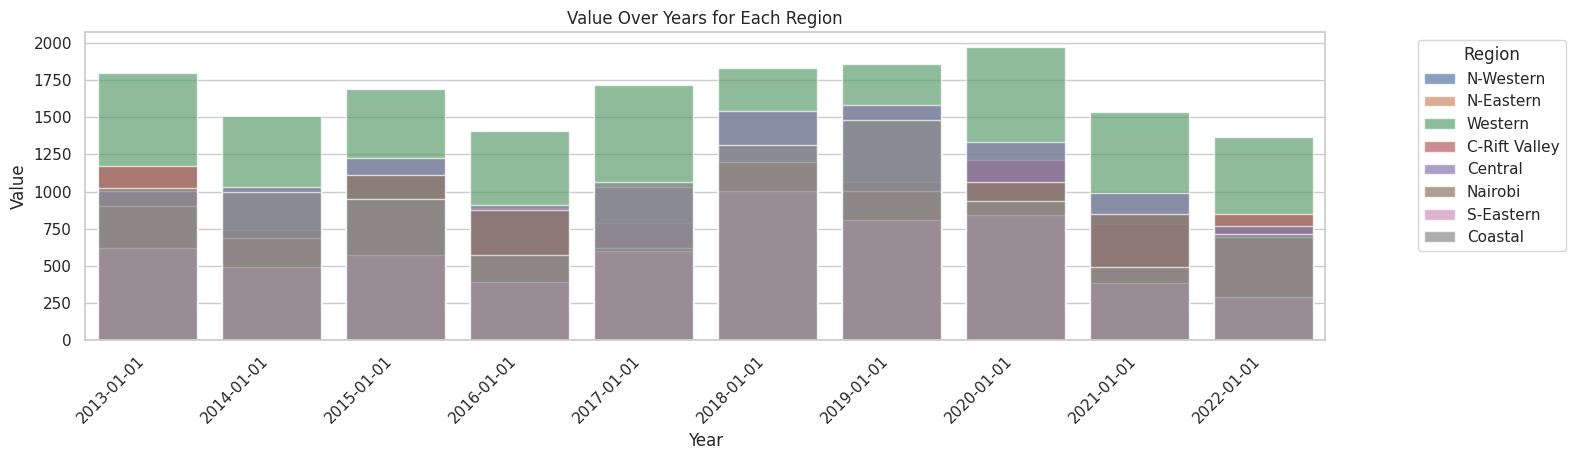

In [288]:

plt.figure(figsize=(16, 4))

# Iterate through each dataset in df_dict
for key, data in df_dict.items():
    sns.barplot(x='Year', y='Value', data=data, label=key, alpha=0.7)

plt.title('Value Over Years for Each Region')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Region', loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()


From this, we can obsereve the year with the least rainfall was 2020

Now let us create a plot to look at the county with the highest rainfal history.

<ipython-input-289-d6643211c0b4>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Region', y='Value', data=total_rainfall, palette='viridis')


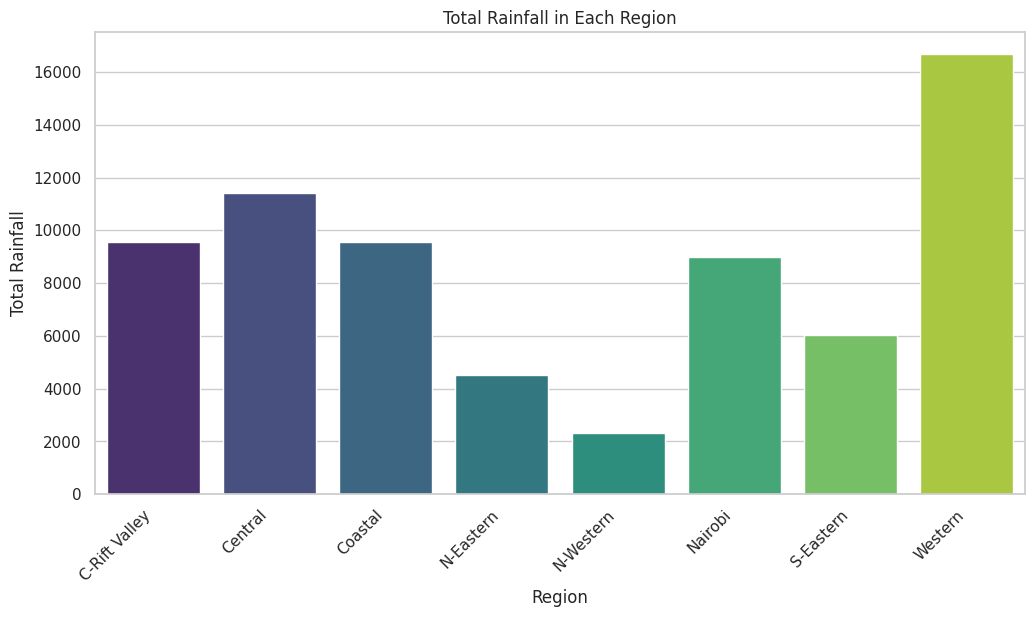

In [289]:

# Concatenate all DataFrames in df_dict into one DataFrame
all_data = pd.concat(df_dict.values())

# Aggregate the data to get total rainfall for each region
total_rainfall = all_data.groupby('Region')['Value'].sum().reset_index()

# Plot the bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='Region', y='Value', data=total_rainfall, palette='viridis')

plt.title('Total Rainfall in Each Region')
plt.xlabel('Region')
plt.ylabel('Total Rainfall')
plt.xticks(rotation=45, ha='right')
plt.show()


From this we can observe that Western has experienced the highest amount of rainfall since 2013 and paradoxically North western the least.

Now that we have gotten a better understanding of our data let us go to modeling.

# Modeling

### Check stationarity

We shall test for stationarity using the ADfuller test

In [290]:
from statsmodels.tsa.stattools import adfuller

# Assuming df_dict is a dictionary of DataFrames
for key, data in df_dict.items():
    result = adfuller(data['Value'])
    print(f'ADF Statistic for {key}: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

    if result[1] <= 0.05:
        print(f'The time series for {key} is likely stationary.')
    else:
        print(f'The time series for {key} is likely non-stationary.')
    print('-' * 40)


ADF Statistic for N-Western: -1.9776828214197575
p-value: 0.2964433068031145
Critical Values: {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625}
The time series for N-Western is likely non-stationary.
----------------------------------------
ADF Statistic for N-Eastern: -1.7434943900613025
p-value: 0.40885355320388345
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}
The time series for N-Eastern is likely non-stationary.
----------------------------------------
ADF Statistic for Western: -12.750176939186561
p-value: 8.568134141303018e-24
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}
The time series for Western is likely stationary.
----------------------------------------
ADF Statistic for C-Rift Valley: -2.173128491279662
p-value: 0.21614239140328817
Critical Values: {'1%': -5.354256481481482, '5%': -3.6462381481481483, '10%': -2.901197777777778}
The time serie

We shall create a difference dictionary consisting of the differenced data.

In [291]:
df_dict_diff = {}
for key in df_dict.keys():
    # Assuming you want to calculate the difference for the 'Value' column
    #df_dict[key] = df_dict[key].set_index('Year').drop(columns='Region')
    df_dict_diff[key] = df_dict[key]['Value'].diff().dropna()




/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


        date     forecast   lower_conf   upper_conf
0 2022-12-31  2266.400448   880.494892  3652.306005
1 2023-12-31  1981.200448   595.293506  3367.107391
2 2024-12-31  2163.600448   777.692120  3549.508777
3 2025-12-31  1880.000448   494.090734  3265.910163
4 2026-12-31  2187.900448   801.989348  3573.811549
5 2027-12-31  2303.300448   917.387962  3689.212935
6 2028-12-31  2327.900448   941.986576  3713.814321
7 2029-12-31  2444.500448  1058.585190  3830.415706
8 2030-12-31  2007.300448   621.383804  3393.217092
9 2031-12-31  1842.400448   456.482419  3228.318478


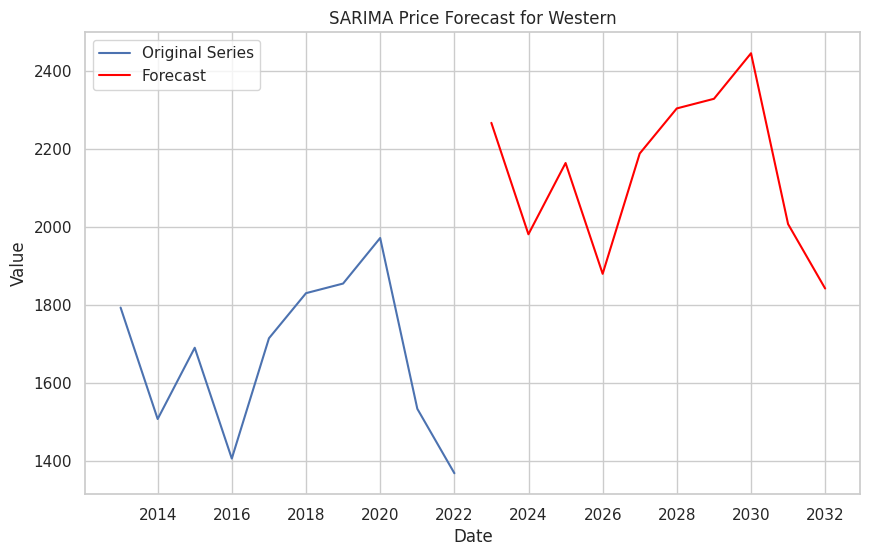

In [343]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

def sarima_model(ref):
    df = pd.DataFrame({
        'value': ref['Value']
    })

    # Convert 'Year' to datetime and set it as the index
    df.index = pd.to_datetime(ref['Year'])

    # Specify SARIMA order (p, d, q, P, D, Q, s)
    order = (3, 1, 3)
    seasonal_order = (1, 1, 1, 10)  # Example: Seasonal order with a period of 12 months

    # Fit SARIMA model
    model = SARIMAX(df['value'], order=order, seasonal_order=seasonal_order)
    result = model.fit(disp=False)

    # Forecast steps
    forecast_steps = 10
    forecast = result.get_forecast(steps=forecast_steps)

    # DataFrame for the forecast
    forecast_df = pd.DataFrame({
        'date': pd.date_range(df.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='Y'),
        'forecast': forecast.predicted_mean.values,
        'lower_conf': forecast.conf_int()['lower value'].values,
        'upper_conf': forecast.conf_int()['upper value'].values
    })

    # Print the forecast DataFrame
    print(forecast_df)

    # Plotting the original series, forecasted values, and confidence intervals
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['value'], label='Original Series')
    plt.plot(forecast_df['date'], forecast_df['forecast'], label='Forecast', color='red')
    plt.title(f'SARIMA Price Forecast for {ref["Region"].unique()[0]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming ref is a DataFrame
sarima_model(df_dict["Western"])


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarni

2023-01-01    1264.250503
2024-01-01    1390.666779
2025-01-01    1688.115091
2026-01-01    1880.440208
2027-01-01    1881.398612
2028-01-01    1707.969813
2029-01-01    1520.366790
2030-01-01    1442.867774
2031-01-01    1512.870622
2032-01-01    1653.540235
Freq: AS-JAN, Name: predicted_mean, dtype: float64


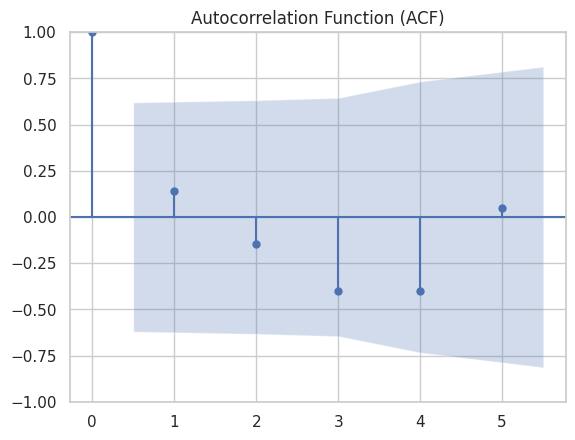

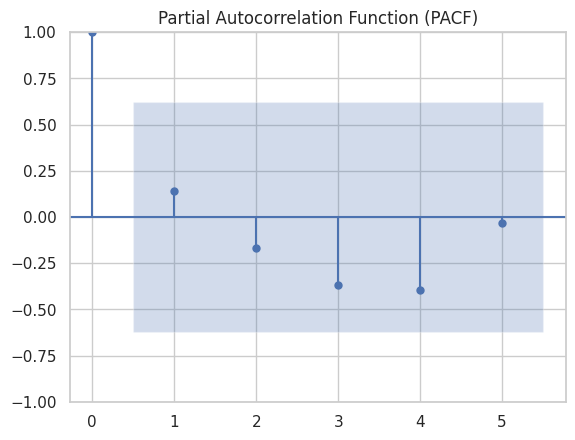

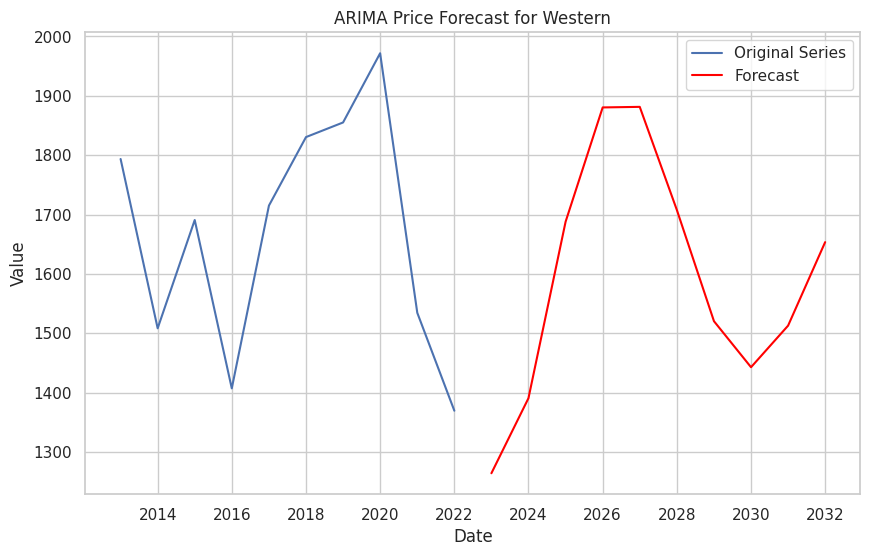

In [344]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def arima_model(ref):
    df = pd.DataFrame({
        'value': ref['Value']
    })

    # Convert 'Year' to datetime and set it as the index
    df.index = pd.to_datetime(ref['Year'])

    # Specify ARIMA order (p, d, q)
    order = (3, 1, 3)

    # Fit ARIMA model
    model = ARIMA(df['value'], order=order)
    result = model.fit()

    # Forecast steps
    forecast_steps = 10
    forecast = result.forecast(steps=forecast_steps)

    # DataFrame for the forecast
    # forecast_df = pd.DataFrame({
    #     'date': pd.date_range(df.index[-1] + pd.DateOffset(1), periods=forecast_steps, freq='Y'),
    #     'forecast': forecast
    # })

    # Print the forecast DataFrame
    print(forecast)

    # Plotting the original series and forecasted values
    # Plotting ACF and PACF to determine ARIMA parameters
    plot_acf(df)
    plt.title('Autocorrelation Function (ACF)')
    plt.show()

    plot_pacf(df)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['value'], label='Original Series')
    plt.plot(forecast, label='Forecast', color='red')
    plt.title(f'ARIMA Price Forecast for {ref["Region"].unique()[0]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming ref is a DataFrame
arima_model(df_dict["Western"])
